In [1]:
import torch
import torch_geometric
import sys
sys.path.append('/Users/pichi/Documents/gca-rom/')
from gca_rom import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui
import numpy as np
from itertools import product

# Define PDE problem

In [2]:
problem_name, variable, mu_space, n_param = pde.problem(3)
print("\nProblem: ", problem_name)
print("Variable: ", variable)
print("Parameters: ", n_param)
argv = gui.hyperparameters_selection(problem_name, variable, n_param)
HyperParams = network.HyperParams(argv)


Problem:  graetz
Variable:  U
Parameters:  2


# Initialize device and set reproducibility

In [3]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cpu


# Load dataset

In [4]:
dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'
dataset = loader.LoadDataset(dataset_dir, variable)

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories = preprocessing.graphs_dataset(dataset, HyperParams)

xx = xyz[0]
yy = xyz[1]

params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

Number of nodes processed:  5160
Number of graphs processed:  200
Length of train dataset:  20
Length of test dataset:  180


# Define the architecture

In [5]:
model = network.Net(HyperParams)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParams.learning_rate, weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train or load a pre-trained network

In [6]:
try:
    model.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'.pt', map_location=torch.device('cpu')))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    training.train(model, optimizer, device, scheduler, params, train_loader, test_loader, train_trajectories, test_trajectories, HyperParams)

Training network


100%|██████████| 50/50 [00:02<00:00, 17.68it/s, Loss(training)=1.38]


Loading best network for epoch:  47


# Evaluate the model

In [7]:
model.to("cpu")
params = params.to("cpu")
vars = "GCA-ROM"
results, latents_map, latents_gca = testing.evaluate(VAR_all, model, graph_loader, params, HyperParams, range(params.shape[0]))

100%|██████████| 200/200 [00:00<00:00, 1136.83it/s]


# Plot the results

100%|██████████| 180/180 [00:00<00:00, 1165.70it/s]


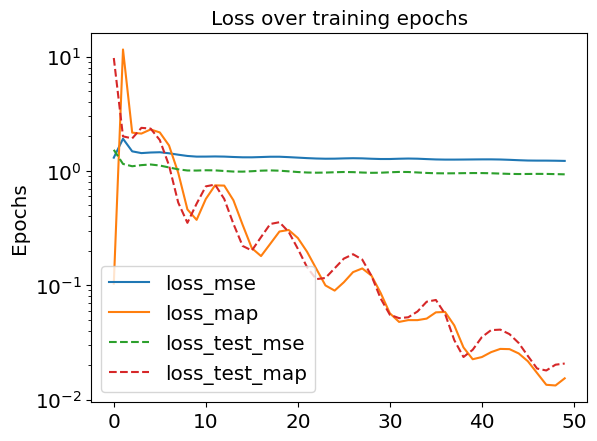

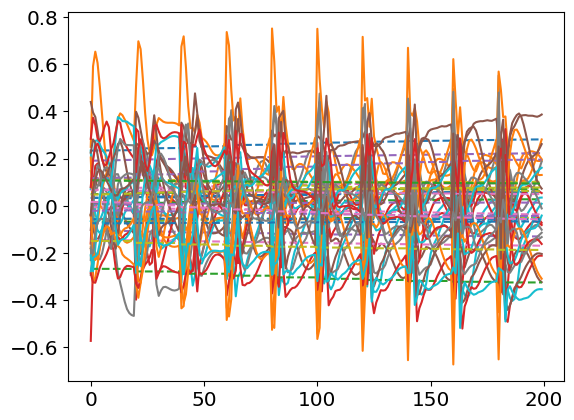

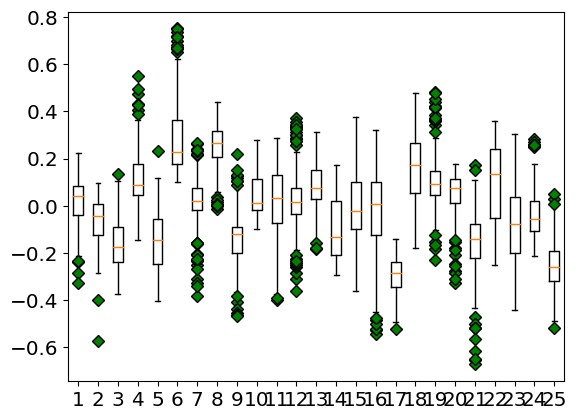

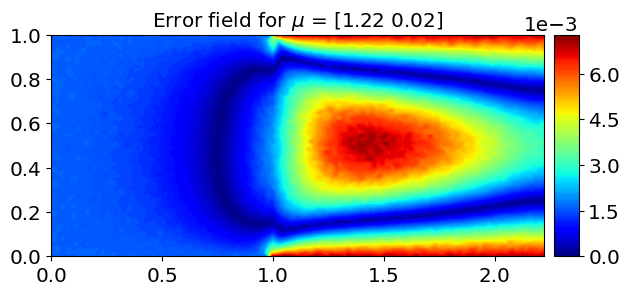

In [8]:
plotting.plot_loss(HyperParams)
plotting.plot_latent(HyperParams, latents_map, latents_gca)
plotting.plot_error(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)

N = 5
snapshots = np.arange(params.shape[0]).tolist()
np.random.shuffle(snapshots)
for SNAP in snapshots[0:N]:
    plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, xyz, params)
    plotting.plot_error_fields(SNAP, results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)

results_test, _, _ = testing.evaluate(VAR_test, model, val_loader, params, HyperParams, test_trajectories)

# Print the errors on the testing set

In [9]:
error_abs, norm = error.compute_error(results_test, VAR_test, scaler_test, HyperParams)
error.print_error(error_abs, norm, vars)
error.save_error(error_abs, norm, HyperParams, vars)


Maximum absolute error for field GCA-ROM =  11.362379915637906
Mean absolute error for field GCA-ROM =  3.678499423935373
Minimum absolute error for field GCA-ROM =  0.8143263674512953

Maximum relative error for field GCA-ROM =  0.4523835419157859
Mean relative error for field GCA-ROM =  0.09399690620919474
Minimum relative error for field GCA-ROM =  0.02029475235218921
